# WIND OUTAGE SUMMARY 

## Wind Speed Index 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
dir_res='./result/'
dir_data='./data/'

#### Data openning and preparation

In [3]:
#Clusters time serie (without declustering)
with open(dir_res+'cluster.txt', 'r') as clstr :
    cluster = np.array([int(i) for i in clstr.readline().replace('\n','')])[:-365]
    Regimes = clstr.readline().replace("'",'').replace('[','').replace(']','').replace('\n','').split(',')

#Wind norm data
data = xr.open_dataset('./data/wind10_eur_19790101_20191231.nc')

In [4]:
#WSI AREA
latS=45
latN=60
lonW=-10
lonE=25
hres = 0.25 #degree
lon = np.arange(lonW,lonE+hres,hres)
lat = np.arange(latS,latN+hres,hres)

In [5]:
#Time index array
d1='1980-01-01T09'
d2='2019-12-31T18'
dates = pd.date_range(d1, d2, freq='D')
jours = np.any([dates.day!=29,dates.month!=2],axis=0)
dates = dates[jours][15:-15] #excluding +15,-15 because nan values (from normalization coeff smoothing)

In [6]:
#Resizing data box
data_wsi = data.sel(longitude = lon, latitude = lat).ws.fillna(0).to_dataset()

#### Latitude-weighted arithmetic mean

In [7]:
wgts = (np.cos(np.deg2rad(data_wsi.latitude)))
data_wsi_weighted = data_wsi.weighted(wgts)

In [8]:
WSI = data_wsi_weighted.mean(dim = ['longitude','latitude']).sel(time = dates)

## Box plot summary 

In [9]:
def season_filter(WSI_regime, season) :
    regime_time = WSI_regime.time.dt.month
    if season == 'DJF' :
        return WSI_regime[np.any([regime_time==12,regime_time==1,regime_time==2],axis=0)]
    if season == 'MAM' :
        return WSI_regime[np.any([regime_time==3,regime_time==4,regime_time==5],axis=0)]
    if season == 'JJA' :
        return WSI_regime[np.any([regime_time==6,regime_time==7,regime_time==8],axis=0)]
    if season == 'SON' :
        return WSI_regime[np.any([regime_time==9,regime_time==10,regime_time==11],axis=0)]

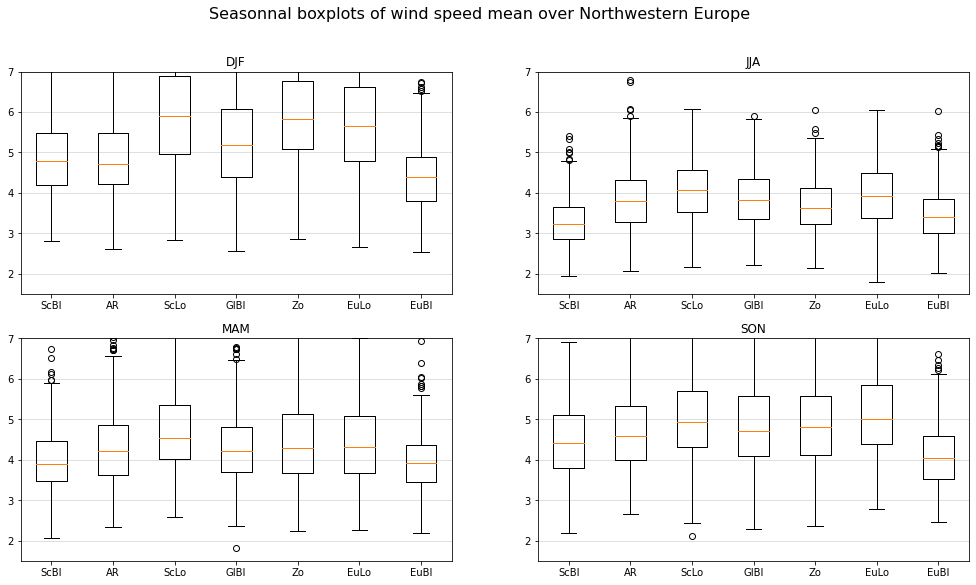

In [10]:
fig = plt.figure(figsize=(17, 9))

WSI_season = WSI.groupby('time.season')
seasons = ['DJF', 'JJA', 'MAM', 'SON']

for plot_index, season in enumerate(seasons) :
    
    ax = fig.add_subplot(2,2,plot_index+1)
    ax.set_title(season)

    WSI_regimes = []
    for index in range(len(Regimes)):
        id_regime = np.any([cluster == index], axis = 0)
        WSI_regime = WSI.ws[id_regime]
        WSI_regimes.append(season_filter(WSI_regime, season))

    ax.boxplot(WSI_regimes, labels = Regimes)
    ax.set_ylim(1.5,7)
    ax.grid(axis = 'y', alpha = 0.5)

plt.suptitle('Seasonnal boxplots of wind speed mean over Northwestern Europe', fontsize = 16)
plt.savefig('figs_wind/wsi_nbox_boxplot_summary.jpg')
plt.show()

## Wind Outage 

#### Computing daily smoothed $\mu-\sigma$ threshold

In [11]:
#daily mean
WSI_dmean = WSI.groupby('time.dayofyear').mean('time')
#smoothed daily mean
WSI_day_mean = xr.concat([
    WSI_dmean.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    WSI_dmean.ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    WSI_dmean.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

In [12]:
#daily standard deviation
WSI_dstd = WSI.groupby('time.dayofyear').std('time')
#smoothed daily standard deviation
WSI_day_std = xr.concat([
    WSI_dstd.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    WSI_dstd.ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    WSI_dstd.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

In [13]:
#Computing threshold and smoothing
empirical_coeff = 1
threshold = (WSI_day_mean - empirical_coeff*WSI_day_std).to_dataset()
threshold_smooth = xr.concat([
    threshold.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    threshold.ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    threshold.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

In [14]:
WO_date = np.array(WSI.where(WSI.groupby('time.dayofyear') < threshold, drop = True).time)

In [15]:
WO_index = [a in WO_date for a in dates]

In [16]:
WO_cluster = cluster[WO_index]

In [17]:
nbr_day = []
print(f'{len(WO_cluster)} days')
print()
print('Regime\t|Repart\t|Occ/reg')
print('--'*12)
for index, regime in enumerate(Regimes) :
    occ = list(WO_cluster).count(index)
    perc = round(occ*100/len(WO_cluster),1)
    nbr_day.append(perc)
    perc_reg = sum(np.any([WO_cluster == index], axis = 0))*100/sum(np.any([cluster == index], axis = 0))
    print(f'{regime[:6]}\t| {perc:4.1f}%\t| {perc_reg:4.1f}%')

2375 days

Regime	|Repart	|Occ/reg
------------------------
ScBl	| 19.4%	| 23.2%
AR	| 12.8%	| 16.6%
ScLo	|  6.8%	|  8.3%
GlBl	| 10.4%	| 12.8%
Zo	| 11.7%	| 11.3%
EuLo	|  8.8%	| 10.8%
EuBl	| 30.2%	| 28.8%


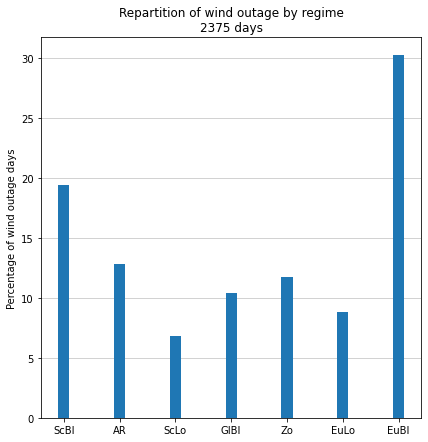

In [18]:
fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(1,2,1)
ax.bar(Regimes,nbr_day, width=0.2, zorder = 2)
ax.grid(axis='y', alpha = 0.7)
ax.set_ylabel('Percentage of wind outage days')
ax.set_title(f'Repartition of wind outage by regime\n{len(WO_cluster)} days')

plt.show()

## Assessing the role of WR transition in WO 

In [19]:
# %%capture cap --no-stderr #use to save print output
for index, regime in enumerate(Regimes) :
    clust_0 = np.any([cluster == index], axis = 0)
    WO_0 = np.array(WO_index) & clust_0
    WO_0_aft = list(cluster[np.roll(WO_0,1)])
    WO_0_bef = list(cluster[np.roll(WO_0,-1)])
    occ_ref = list(cluster[WO_0]).count(index)
    print(f'{regime}  \t|  J-1\t|   J\t|  J+1')
    print('--'*15)
    for index, regime in enumerate(Regimes) :
        occ_bef = (WO_0_bef).count(index)
        occ_aft = (WO_0_aft).count(index)
        occ = list(cluster[WO_0]).count(index)
        print(f'{regime}  \t| {occ_bef*100/occ_ref:4.1f}\t| {occ*100/occ_ref:4.1f}\t| {occ_aft*100/occ_ref:4.1f}')
    print()
    print('=='*15)
    print()

ScBl  	|  J-1	|   J	|  J+1
------------------------------
ScBl  	| 72.2	| 100.0	| 75.2
AR  	|  3.3	|  0.0	|  5.9
ScLo  	|  0.7	|  0.0	|  0.2
GlBl  	|  5.0	|  0.0	|  5.4
Zo  	|  4.8	|  0.0	|  2.2
EuLo  	|  1.7	|  0.0	|  3.3
EuBl  	| 12.4	|  0.0	|  7.8


AR  	|  J-1	|   J	|  J+1
------------------------------
ScBl  	| 11.2	|  0.0	|  4.3
AR  	| 70.3	| 100.0	| 71.6
ScLo  	|  1.0	|  0.0	|  2.0
GlBl  	|  3.6	|  0.0	| 10.9
Zo  	|  0.0	|  0.0	|  0.0
EuLo  	|  5.0	|  0.0	|  4.0
EuBl  	|  8.9	|  0.0	|  7.3


ScLo  	|  J-1	|   J	|  J+1
------------------------------
ScBl  	|  0.6	|  0.0	|  2.5
AR  	|  7.5	|  0.0	|  3.1
ScLo  	| 55.9	| 100.0	| 61.5
GlBl  	|  0.6	|  0.0	|  4.3
Zo  	|  8.7	|  0.0	| 12.4
EuLo  	|  9.3	|  0.0	|  9.9
EuBl  	| 17.4	|  0.0	|  6.2


GlBl  	|  J-1	|   J	|  J+1
------------------------------
ScBl  	|  8.5	|  0.0	| 10.6
AR  	| 13.4	|  0.0	|  5.3
ScLo  	|  2.0	|  0.0	|  0.8
GlBl  	| 67.1	| 100.0	| 73.6
Zo  	|  2.4	|  0.0	|  3.7
EuLo  	|  5.3	|  0.0	|  2.8
EuBl  	|  1.2	|  0.0

In [20]:
# with open(dir_res+'WR_transition.txt', 'w') as f: #save output in a txt file
#     f.write(cap.stdout)